In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("C:\\Users\\Sarrang\\kepler\\df.csv")

In [7]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

## Splitting the dataset into the Training set and Test set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Feature Scaling

In [9]:
"""feature scaling all except'kepoi_name' and 'koi_tce_delivname'"""

"feature scaling all except'kepoi_name' and 'koi_tce_delivname'"

### Applying Box-cox transformation
The Box-Cox transformation is a statistical technique used to stabilize variance and make data more normally distributed. It is particularly useful when dealing with data that violates the assumptions of normality required by many statistical models.

In essence, the Box-Cox transformation applies a power transformation to the data, defined by the formula:


![Screenshot%202024-02-06%20202654.png](attachment:Screenshot%202024-02-06%20202654.png)
where
y is the original data and

λ is a parameter that determines the type of transformation applied. The optimal value of

λ is determined through maximum likelihood estimation or other optimization techniques.

The Box-Cox transformation works well for data that follows a wide range of distributions, including skewed distributions. It is commonly used in regression analysis, time series analysis, and other statistical modeling tasks to improve the validity of assumptions and enhance the performance of models.

In [10]:
from scipy.stats import boxcox
columns_to_transform = ['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']

for column in columns_to_transform:
    X_train[column] = X_train[column] - X_train[column].min() + 1
    X_train[column], _ = boxcox(X_train[column])


### standardizing to bring into same range

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from joblib import load,dump

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_score)

best_rf_model = grid_search.best_estimator_

test_accuracy = best_rf_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

dump(best_rf_model, "C:\\Users\\Sarrang\\kepler\\saved joblib models\\rf_kepler.joblib")

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.9870605311578148
Test Accuracy: 0.9550444328280188


['C:\\Users\\Sarrang\\kepler\\saved joblib models\\rf_kepler.joblib']

In [32]:
from joblib import load

rf= load("C:\\Users\\Sarrang\\kepler\\saved joblib models\\rf_kepler.joblib")

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [33]:
y_pred=rf.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       887
           1       0.98      0.93      0.96      1026

    accuracy                           0.96      1913
   macro avg       0.95      0.96      0.95      1913
weighted avg       0.96      0.96      0.96      1913



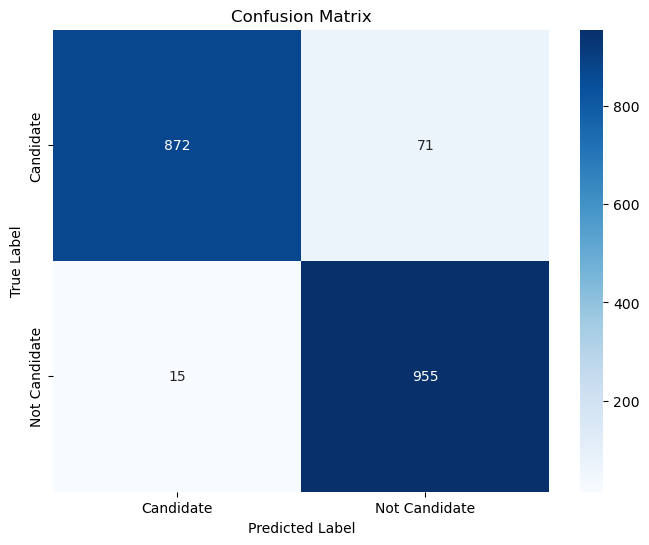

In [34]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_pred,y_test))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Candidate', 'Not Candidate'],
            yticklabels=['Candidate', 'Not Candidate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

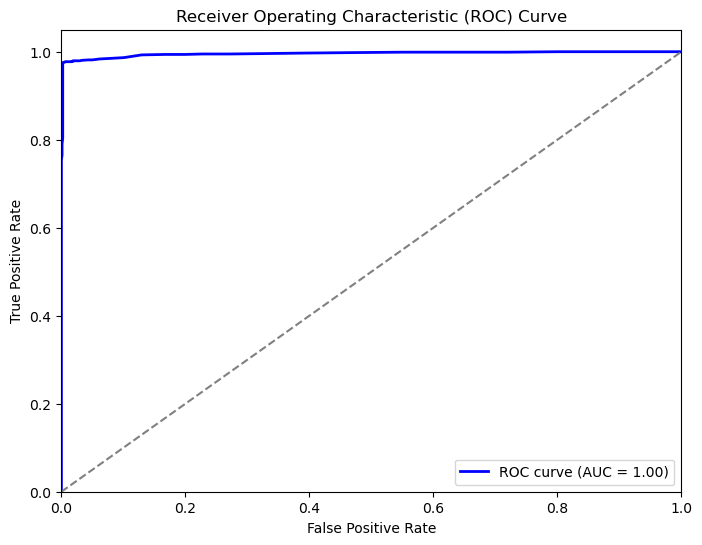

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
auc_roc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [36]:
print(auc_roc)

0.9955811131396837
